In [1]:
lang_suffixes = {"english": "en", "sinhala" : "si", "nepali": "ne"}
from datasets import load_dataset
import pandas as pd 
ds_eng_dev = load_dataset("openlanguagedata/flores_plus", "eng_Latn", split="dev")
ds_sin_dev = load_dataset("openlanguagedata/flores_plus", "sin_Sinh", split="dev")
ds_npi_dev = load_dataset("openlanguagedata/flores_plus", "npi_Deva", split="dev")
eng_lines = [(sentence + "\n") for sentence in list(pd.DataFrame(ds_eng_dev)["text"])]
sin_lines = [(sentence + "\n") for sentence in list(pd.DataFrame(ds_sin_dev)["text"])]
npi_lines = [(sentence + "\n") for sentence in list(pd.DataFrame(ds_npi_dev)["text"])]
with open("data/en-si/eng_Latn.dev", "w", encoding="utf-8") as eng1, open("data/en-ne/eng_Latn.dev", "w", encoding="utf-8") as eng2, open("data/en-si/sin_Sinh.dev", "w", encoding="utf-8") as sin, open("data/en-ne/npi_Deva.dev", "w", encoding="utf-8") as npi:
    eng1.writelines(eng_lines)
    eng2.writelines(eng_lines)
    sin.writelines(sin_lines)
    npi.writelines(npi_lines)
import os 
os.makedirs("evaluation/en-ne/", exist_ok=True)
os.makedirs("evaluation/ne-en/", exist_ok=True)
os.makedirs("evaluation/en-si/", exist_ok=True)
os.makedirs("evaluation/si-en/", exist_ok=True)

/home/tanmay/miniconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import filtering as filtering
def create_corpus_files(list, train=False, langs=["english", "sinhala"]):
    other=""
    for lang in langs:
        if lang!="english":
            other=lang
    lang1_list = list[0].split("\n")
    lang2_list = list[1].split("\n")
    lang1_ids = []
    lang2_ids = []
    for item in lang1_list:
        lang1_ids.append(item.split("\t")[0])
    for item in lang2_list:
        lang2_ids.append(item.split("\t")[0])
    gold_list = list[2].split("\n")
    lang1_corpus_lines = []
    lang2_corpus_lines = []
    for line in lang1_list:
        line = filtering.preprocess_line(line)
        lang1_corpus_lines.append(line)
    for line in lang2_list:
        line = filtering.preprocess_line(line)
        lang2_corpus_lines.append(line)
    addition = "train"
    if train==False: 
        addition = "test"
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{lang_suffixes[langs[0]]}.source_synthetic_corpus.txt", "w", encoding="utf-8") as f:
        for line in lang1_corpus_lines:
            f.write(f"{line}\n")
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{lang_suffixes[langs[1]]}.target_synthetic_corpus.txt", "w", encoding="utf-8") as f:
        for line in lang2_corpus_lines:
            f.write(f"{line}\n")
    return [dict(zip(lang1_ids, lang1_corpus_lines)), dict(zip(lang2_ids, lang2_corpus_lines)), gold_list]

def create_synthetic_corpora(mono_file1, mono_file2, par_file1, par_file2, langs):

    '''Create synthetic parallel corpora to evaluate pipeline by injecting real parallel sentences into different monolingual corpora'''
#
    import bucc_style_dataset as bsd
    lang1_mono_lines = []
    lang2_mono_lines = []
    with open(mono_file1, "r", encoding="utf-8") as f:
        for line in f: 
            line = filtering.preprocess_line(line)
            split = line.split("\t")
            line = line.split("\t")[1]
            lang1_mono_lines.append(split[1])
    with open(mono_file2, "r", encoding="utf-8") as f:
        for line in f:
            line = filtering.preprocess_line(line)
            split  =line.split("\t")
            line = line.split("\t")[1]
            lang2_mono_lines.append(split[1])
    

    lang1_par_lines = []
    lang2_par_lines = []

    with open(par_file1, "r", encoding="utf-8") as f:
        for line in f: 
            line = filtering.preprocess_line(line)
            lang1_par_lines.append(line)
    with open(par_file2, "r", encoding="utf-8") as f:
        for line in f:
            line = filtering.preprocess_line(line)
            lang2_par_lines.append(line)

    train_list, test_list = bsd.split_shuffle_create_corpus(lang1_mono_lines, lang2_mono_lines, lang1_par_lines, lang2_par_lines)
    train_res = create_corpus_files(train_list, train=True)
    test_res = create_corpus_files(test_list, train=False)
    total_res = train_res + test_res
    return total_res

2025-07-14 14:16:55,859 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-07-14 14:16:55,928 | INFO | laser_encoders.download_models |  - laser2.pt already downloaded
2025-07-14 14:16:55,930 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-07-14 14:16:55,930 | INFO | laser_encoders.download_models |  - laser2.cvocab already downloaded
2025-07-14 14:16:56,530 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-07-14 14:16:56,616 | INFO | laser_encoders.download_models |  - laser3-sin_Sinh.v1.pt already downloaded
2025-07-14 14:16:56,618 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-07-14 14:16:56,619 | INFO | laser_encoders.download_models |  - laser2.cvocab already downloaded
2025-07-14 14:16:59,060 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-07-14 14:16:59,110 | INFO | laser_encoders.download_models |  - laser3-npi_Deva.v1.pt al

Some weights of XLMRobertaModel were not initialized from the model checkpoint at yihongLiu/furina and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at yihongLiu/furina-indic and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def mine_corpora(lang1_dict, lang2_dict, langs, model, train=False):

    '''Convert synthetic corpora to Word2Vec format to perform sentence mining'''
    addition = ""
    if train==False:
        addition = "test"
    else:
        addition = "train"
    lang1_ids = [key for key, value in lang1_dict.items()]
    lang2_ids = [key for key, value in lang2_dict.items()]
    lang1_vals = [value for key, value in lang1_dict.items()]
    lang2_vals = [value for key, value in lang2_dict.items()]
    import filtering as filtering
    e1 = filtering.to_multilingual_embedding(langs[0], lang1_vals, model)
    e2 = filtering.to_multilingual_embedding(langs[1], lang2_vals, model)  
    source_lines = [f"{e1.shape[0]} {e1.shape[1]}"]
    target_lines = [f"{e2.shape[0]} {e2.shape[1]}"]
    for id, encoding in zip(lang1_ids, e1):
        encoding_str = " ".join([f"{x:.4f}" for x in encoding])
        source_lines.append(f"{id} {encoding_str}")
    for id, encoding in zip(lang2_ids, e2):
        encoding_str = " ".join([f"{x:.4f}" for x in encoding])
        target_lines.append(f"{id} {encoding_str}")  
    other = ""
    for lang in langs: 
        if lang!="english":
            other = lang
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{langs[0]}.{model}.source.vec", "w", encoding="utf-8") as f: 
        for line in source_lines:
            f.write(f"{line}\n")
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{langs[1]}.{model}.target.vec", "w", encoding="utf-8") as f: 
        for line in target_lines:
            f.write(f"{line}\n")
    import bilingual_nearest_neighbor as bnn 
    bnn.main(source_embeddings=f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{langs[0]}.{model}.source.vec", target_embeddings=f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{langs[1]}.{model}.target.vec", output=f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.mined.txt", binary=0, method="csls")

In [4]:
def plot_mining_distribution(file):
    import filtering as filtering 
    import matplotlib.pyplot as plt 
    import numpy as np 
    mining_scores = []
    with open(file, "r", encoding="utf-8") as f:
        for line in f: 
            line = filtering.preprocess_line(line)
            line = line.split("\t")[2]
            mining_scores.append(float(line)) 
    # plt.figure(figsize=(8, 5))
    plt.hist(mining_scores, bins=30, color='skyblue', edgecolor='black')
    plt.title("Distribution of Mining Scores")
    plt.xlabel("Mining Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [5]:
def evaluate_mining(mined_file, lang1_dict, lang2_dict, gold_list, langs, model, training=False, threshold=None):
    import filtering as filtering
    '''Create gold file and prediction file to calculate F-measure'''
    mined_lang1_lines = []
    mined_lang2_lines = []
    mined_scores = []
    with open(mined_file, "r", encoding="utf-8") as f:
        for line in f:
            split = line.split("\t")
            mined_lang1_lines.append(split[0])
            mined_lang2_lines.append(split[1])
            mined_scores.append(float(split[2]))
    import pandas as pd
    df = pd.DataFrame({langs[0]: mined_lang1_lines, langs[1]: mined_lang2_lines, "mining score": mined_scores})
    addition = ""
    if training:
        addition = "train"
        import statistics 
        score_mean = statistics.fmean(mined_scores)
        score_std = statistics.stdev(mined_scores)
        threshold = score_mean + 2*score_std
    else:
        addition = "test"
    # model_thresholds = {"labse": 0.4, "laser": 0.05, "furina": 0.006, "furina-indic": 0.012}
    # threshold = model_thresholds[model]
    df = filtering.static_filter(df, "mining score", threshold)
    # if df.shape[0] > len(gold_list):
    #     df = df[:len(gold_list)]
    other = ""
    for lang in langs: 
        if lang!="english":
            other = lang
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.gold.txt", "w", encoding="utf-8") as f:
        for line in gold_list:
            f.write(f"{line}\n")
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.prediction.txt", "w", encoding="utf-8") as f:
        for line1, line2 in zip(list(df[langs[0]]), list(df[langs[1]])):
            f.write(f"{line1}\t{line2}\n")
    import bucc_f_score as bfs
    bfs.main(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.prediction.txt", f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.gold.txt")
    mined_ids = []
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.prediction.txt", "r", encoding="utf-8") as f:
        for line in f:
            mined_ids.append(filtering.preprocess_line(line))
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.prediction_text.txt", "w", encoding="utf-8") as f:
        for line in mined_ids:
            split = line.split("\t")
            f.write(f"{lang1_dict[split[0]]}\t{lang2_dict[split[1]]}\n")
    return threshold 


In [6]:
def run_experiment(model, mono1="data/en-si/eng_news_2024_30K-sentences.txt",
                   mono2="data/en-si/sin_wikipedia_2021_30K-sentences.txt",
                   par1="data/en-si/eng_Latn.dev",
                   par2="data/en-si/sin_Sinh.dev", langs=["english", "sinhala"]):
    
    '''Perform the embedding test for a given model'''
    other = ""
    lang_suffixes = {"english": "en", "sinhala" : "si", "nepali": "ne"}
    for lang in langs: 
        if lang!="english":
            other = lang
    res = create_synthetic_corpora(mono1, mono2, par1, par2, langs)
    train_lang1_dict = res[0]
    train_lang2_dict = res[1]
    train_gold_list = res[2]
    test_lang1_dict = res[3]
    test_lang2_dict = res[4]
    test_gold_list = res[5] 
    if (os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/train.{langs[0]}.{model}.source.vec") and 
     os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/train.{langs[1]}.{model}.target.vec") and 
    os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/train.{model}.mined.txt")): 
        print("Skipped corpora mining as results already exist!")
    else: 
        mine_corpora(train_lang1_dict, train_lang2_dict, langs=langs, model=model,train=True)
    plot_mining_distribution(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/train.{model}.mined.txt")
    threshold = evaluate_mining(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/train.{model}.mined.txt", train_lang1_dict, train_lang2_dict, train_gold_list, langs, model, training=True)
    print(f"Training dataset threshold for similarity score is {threshold}")
    test_gold_list = res[5] 
    if (os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{langs[0]}.{model}.source.vec") and 
     os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{langs[1]}.{model}.target.vec") and 
    os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{model}.mined.txt")): 
        print("Skipped corpora mining as results already exist!")
    else: 
        mine_corpora(test_lang1_dict, test_lang2_dict, langs=langs, model=model,train=False) 
    plot_mining_distribution(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{model}.mined.txt")
    evaluate_mining(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{model}.mined.txt", test_lang1_dict, test_lang2_dict, test_gold_list, langs, model, training=False, threshold=threshold)
    

Batches: 100%|██████████| 243/243 [06:25<00:00,  1.59s/it]


2025-07-06 17:25:07,757 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-07-06 17:25:08,223 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-07-06 17:25:08,242 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-07-06 17:25:08,244 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.english.labse.source.vec
2025-07-06 17:25:09,679 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-si/train.english.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T17:25:09.679662', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 17:25:09

100%|██████████| 7749/7749 [00:00<00:00, 43828.77it/s]

2025-07-06 17:25:12,263 | WARNING | root | Saving results...


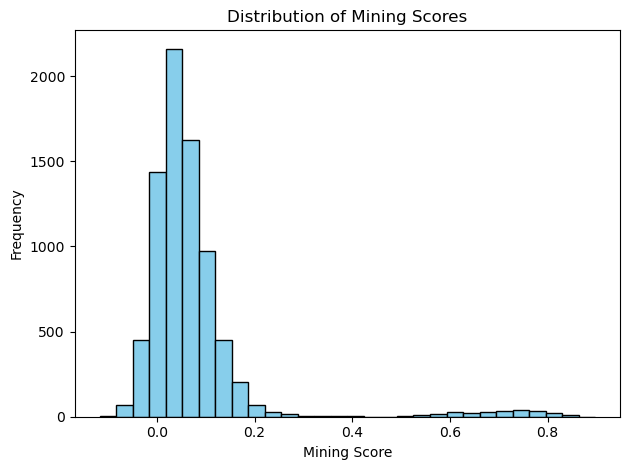

PRECISION,RECALL,F1
0.9763779527559056,0.9959839357429718,0.9860834990059643
Training dataset threshold for similarity score is 0.3234220608973159


Batches: 100%|██████████| 727/727 [20:28<00:00,  1.69s/it]


2025-07-06 18:02:41,905 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.english.labse.source.vec
2025-07-06 18:02:46,130 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-si/test.english.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T18:02:46.130306', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 18:02:46,131 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.sinhala.labse.target.vec
2025-07-06 18:02:50,326 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-si/test.sinhala.labse.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T18:02:50.326460', 'gens

100%|██████████| 23248/23248 [00:00<00:00, 45786.37it/s]

2025-07-06 18:03:01,721 | WARNING | root | Saving results...


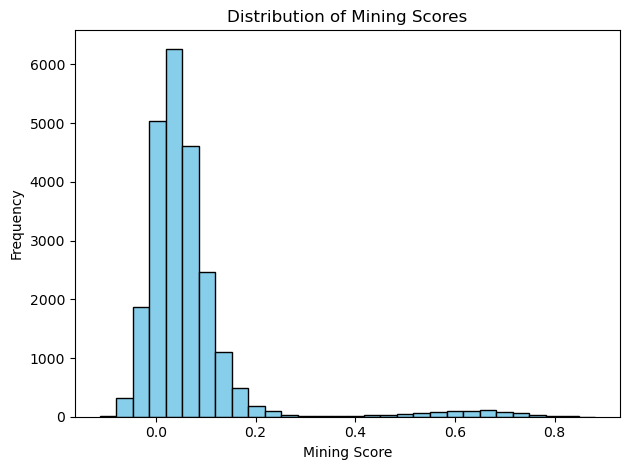

PRECISION,RECALL,F1
0.9906914893617021,0.9959893048128342,0.9933333333333334


In [35]:
run_experiment("labse")

/home/tanmay/miniconda3/envs/thesis_env/lib/python3.9/site-packages/fairseq/models/transformer/transformer_encoder.py:281: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  x = torch._nested_tensor_from_mask(


2025-07-06 18:22:27,002 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.english.laser.source.vec
2025-07-06 18:22:28,692 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 1024) matrix of type float32 from evaluation/en-si/train.english.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T18:22:28.692414', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 18:22:28,693 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.sinhala.laser.target.vec
2025-07-06 18:22:30,391 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 1024) matrix of type float32 from evaluation/en-si/train.sinhala.laser.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T18:22:30.391806', '

100%|██████████| 7749/7749 [00:00<00:00, 44874.20it/s]

2025-07-06 18:22:32,064 | WARNING | root | Saving results...


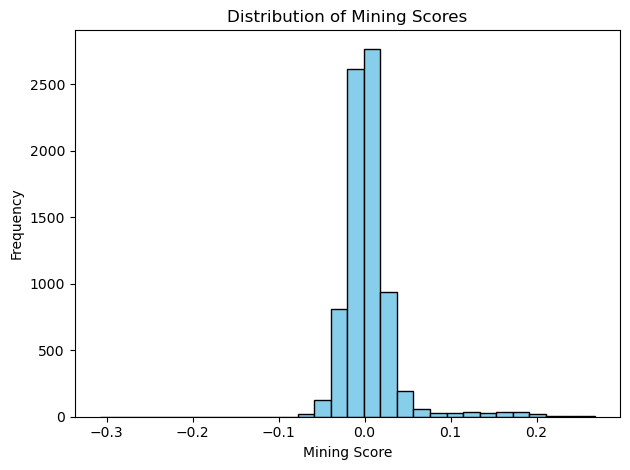

PRECISION,RECALL,F1
0.9224489795918367,0.9076305220883534,0.9149797570850202
Training dataset threshold for similarity score is 0.06826909790592373
2025-07-06 19:14:16,284 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.english.laser.source.vec
2025-07-06 19:14:21,475 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix of type float32 from evaluation/en-si/test.english.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T19:14:21.475268', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 19:14:21,476 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.sinhala.laser.target.vec
2025-07-06 19:14:26,596 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix o

100%|██████████| 23248/23248 [00:00<00:00, 50620.70it/s]

2025-07-06 19:14:41,281 | WARNING | root | Saving results...


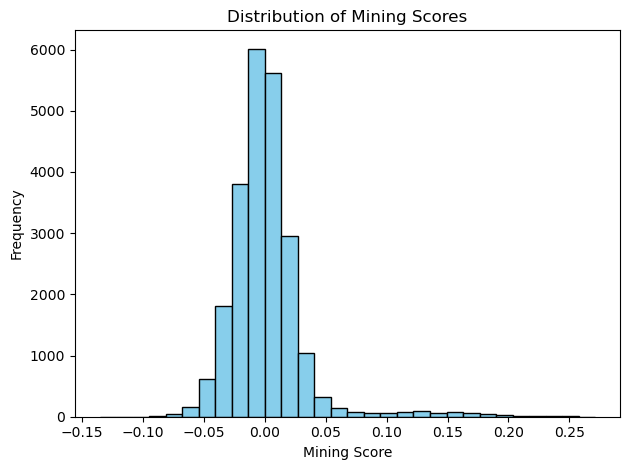

PRECISION,RECALL,F1
0.9272997032640949,0.8355614973262032,0.8790436005625879


In [36]:
run_experiment("laser")

2025-07-06 19:29:31,612 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.english.furina.source.vec
2025-07-06 19:29:32,892 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-si/train.english.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T19:29:32.891971', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 19:29:32,893 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.sinhala.furina.target.vec
2025-07-06 19:29:34,153 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/en-si/train.sinhala.furina.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T19:29:34.153821',

100%|██████████| 7749/7749 [00:00<00:00, 43368.22it/s]

2025-07-06 19:29:35,438 | WARNING | root | Saving results...


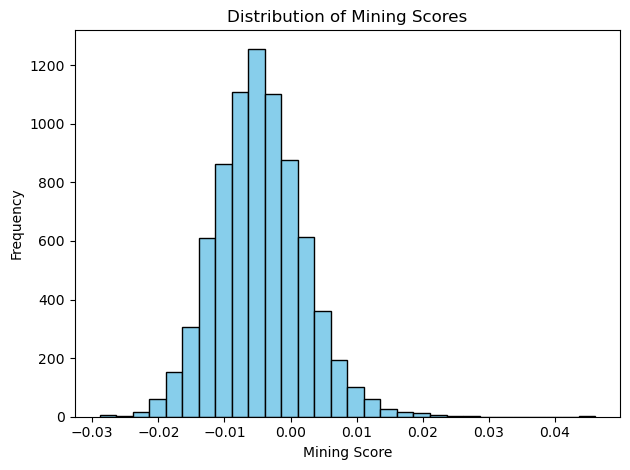

PRECISION,RECALL,F1
0.0625,0.05622489959839357,0.05919661733615222
Training dataset threshold for similarity score is 0.00872797370021191
2025-07-06 20:12:52,493 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.english.furina.source.vec
2025-07-06 20:12:57,889 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-si/test.english.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T20:12:57.889032', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 20:12:57,889 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.sinhala.furina.target.vec
2025-07-06 20:13:01,920 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type fl

100%|██████████| 23248/23248 [00:00<00:00, 52759.00it/s]

2025-07-06 20:13:11,948 | WARNING | root | Saving results...


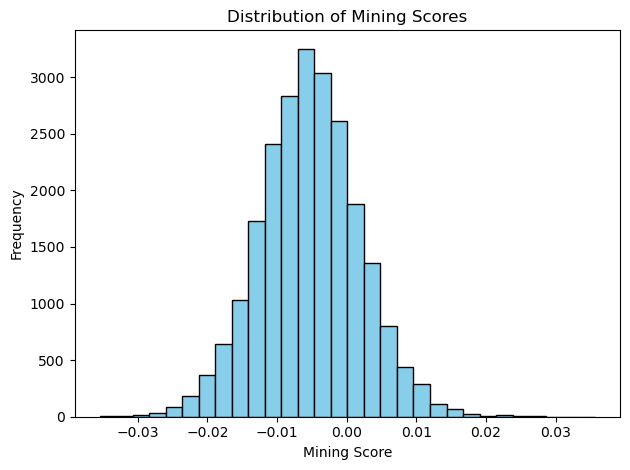

PRECISION,RECALL,F1
0.08500772797527048,0.07352941176470588,0.07885304659498209


In [37]:
run_experiment("furina")

2025-07-06 20:27:55,363 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.english.furina-indic.source.vec
2025-07-06 20:27:56,635 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-si/train.english.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T20:27:56.635251', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 20:27:56,636 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.sinhala.furina-indic.target.vec
2025-07-06 20:27:57,924 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/en-si/train.sinhala.furina-indic.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025

100%|██████████| 7749/7749 [00:00<00:00, 42637.60it/s]

2025-07-06 20:27:59,244 | WARNING | root | Saving results...


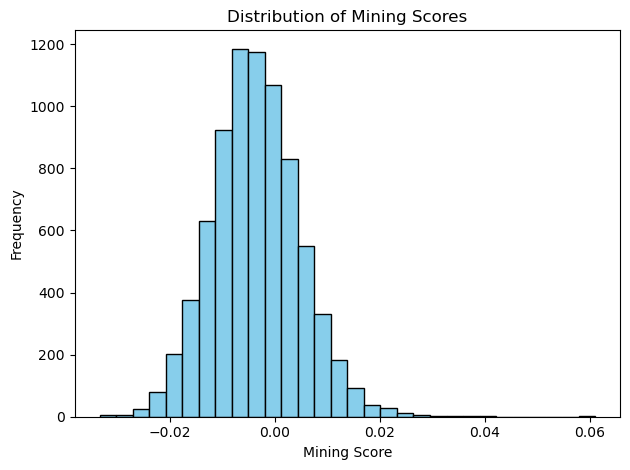

PRECISION,RECALL,F1
0.09389671361502347,0.08032128514056225,0.08658008658008658
Training dataset threshold for similarity score is 0.013101708643548619
2025-07-06 21:11:16,285 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.english.furina-indic.source.vec
2025-07-06 21:11:20,335 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-si/test.english.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T21:11:20.335658', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 21:11:20,336 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.sinhala.furina-indic.target.vec
2025-07-06 21:11:24,158 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loade

100%|██████████| 23248/23248 [00:00<00:00, 53114.84it/s]

2025-07-06 21:11:33,922 | WARNING | root | Saving results...


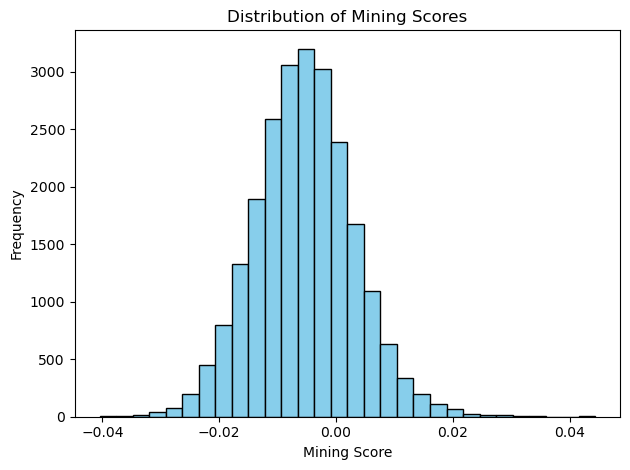

PRECISION,RECALL,F1
0.2119205298013245,0.12834224598930483,0.15986677768526228


In [38]:
run_experiment("furina-indic")
#dfdfdsfdf

Batches: 100%|██████████| 243/243 [05:07<00:00,  1.26s/it]


2025-07-12 14:16:42,506 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-07-12 14:16:42,541 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-07-12 14:16:42,547 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-07-12 14:16:42,548 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.sinhala.labse.source.vec
2025-07-12 14:16:43,817 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/si-en/train.sinhala.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T14:16:43.817086', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-12 14:16:43

100%|██████████| 7748/7748 [00:00<00:00, 44308.34it/s]

2025-07-12 14:16:46,450 | WARNING | root | Saving results...


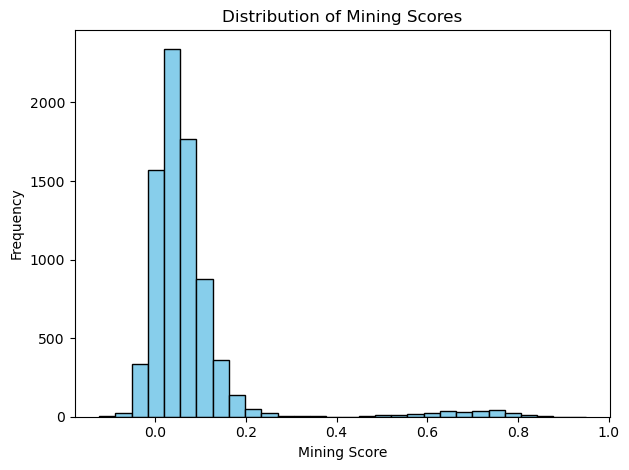

PRECISION,RECALL,F1
0.9839357429718876,0.9839357429718876,0.9839357429718876
Training dataset threshold for similarity score is 0.3153189374484597


Batches: 100%|██████████| 727/727 [14:17<00:00,  1.18s/it]


2025-07-12 14:48:14,660 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.sinhala.labse.source.vec
2025-07-12 14:48:18,504 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/si-en/test.sinhala.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T14:48:18.504295', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-12 14:48:18,505 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.english.labse.target.vec
2025-07-12 14:48:22,312 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/si-en/test.english.labse.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T14:48:22.312556', 'gens

100%|██████████| 23248/23248 [00:00<00:00, 43007.71it/s]

2025-07-12 14:48:34,693 | WARNING | root | Saving results...


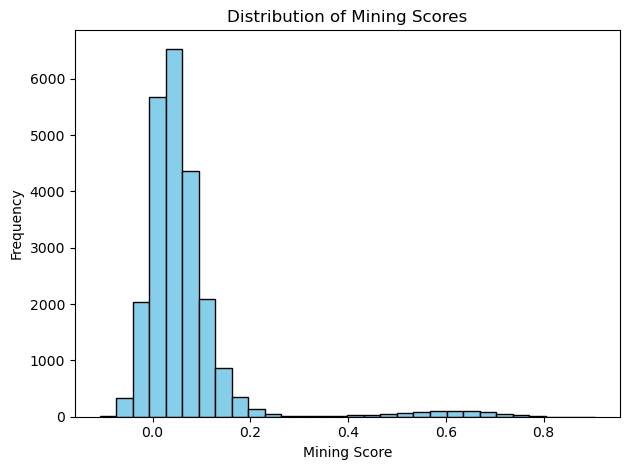

PRECISION,RECALL,F1
0.9880794701986755,0.9973262032085561,0.9926813040585495


In [8]:
run_experiment("labse", 
               "data/en-si/sin_wikipedia_2021_30K-sentences.txt",
               "data/en-si/eng_news_2024_30K-sentences.txt",
               "data/en-si/sin_Sinh.dev",
               "data/en-si/eng_Latn.dev",
               ["sinhala", "english"]
               )

/home/tanmay/miniconda3/envs/thesis_env/lib/python3.9/site-packages/fairseq/models/transformer/transformer_encoder.py:281: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  x = torch._nested_tensor_from_mask(


2025-07-12 16:55:44,541 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.sinhala.laser.source.vec
2025-07-12 16:55:46,166 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 1024) matrix of type float32 from evaluation/si-en/train.sinhala.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T16:55:46.166265', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-12 16:55:46,167 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.english.laser.target.vec
2025-07-12 16:55:47,791 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 1024) matrix of type float32 from evaluation/si-en/train.english.laser.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T16:55:47.791329', '

100%|██████████| 7748/7748 [00:00<00:00, 48225.56it/s]

2025-07-12 16:55:49,176 | WARNING | root | Saving results...


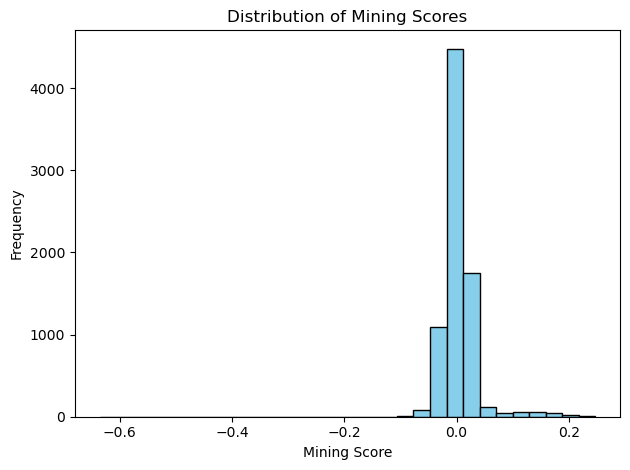

PRECISION,RECALL,F1
0.9298245614035088,0.8514056224899599,0.8888888888888888
Training dataset threshold for similarity score is 0.06867509999138709
2025-07-12 17:48:13,532 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.sinhala.laser.source.vec
2025-07-12 17:48:19,090 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix of type float32 from evaluation/si-en/test.sinhala.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T17:48:19.090449', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-12 17:48:19,091 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.english.laser.target.vec
2025-07-12 17:48:24,628 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix o

100%|██████████| 23248/23248 [00:00<00:00, 45714.06it/s]

2025-07-12 17:48:37,210 | WARNING | root | Saving results...


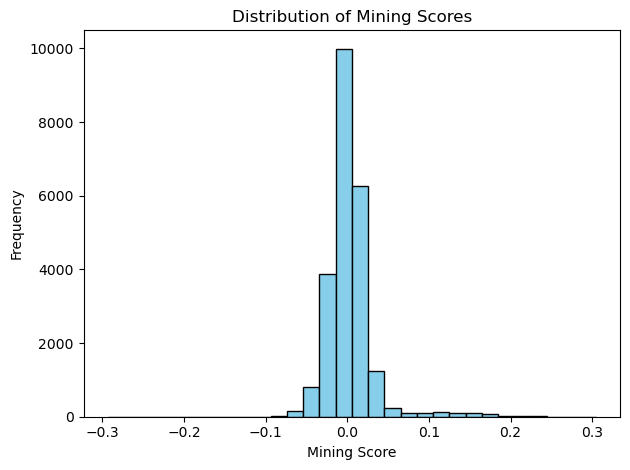

PRECISION,RECALL,F1
0.9577464788732394,0.8181818181818182,0.8824801730353281


In [11]:
run_experiment("laser", 
               "data/en-si/sin_wikipedia_2021_30K-sentences.txt",
               "data/en-si/eng_news_2024_30K-sentences.txt",
               "data/en-si/sin_Sinh.dev",
               "data/en-si/eng_Latn.dev",
               ["sinhala", "english"]
               )

2025-07-12 15:03:14,940 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.sinhala.furina.source.vec
2025-07-12 15:03:16,219 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/si-en/train.sinhala.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T15:03:16.219940', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-12 15:03:16,220 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.english.furina.target.vec
2025-07-12 15:03:17,492 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/si-en/train.english.furina.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T15:03:17.492121',

100%|██████████| 7748/7748 [00:00<00:00, 48137.34it/s]

2025-07-12 15:03:18,688 | WARNING | root | Saving results...


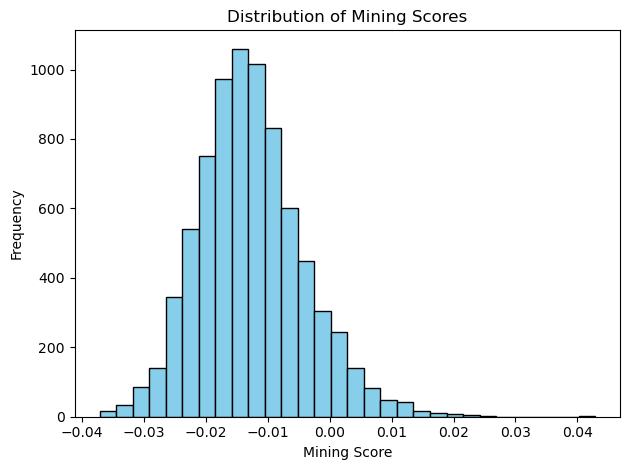

PRECISION,RECALL,F1
0.09125475285171103,0.0963855421686747,0.09375
Training dataset threshold for similarity score is 0.004437060695623801
2025-07-12 15:44:10,000 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.sinhala.furina.source.vec
2025-07-12 15:44:13,787 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/si-en/test.sinhala.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T15:44:13.787331', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-12 15:44:13,788 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.english.furina.target.vec
2025-07-12 15:44:17,596 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type f

100%|██████████| 23248/23248 [00:00<00:00, 53243.20it/s]

2025-07-12 15:44:27,120 | WARNING | root | Saving results...


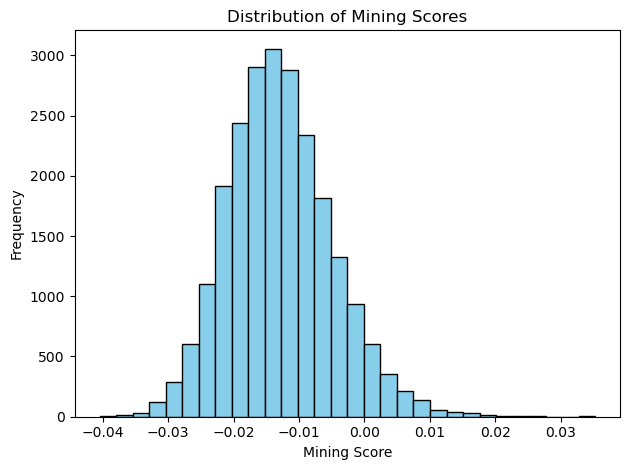

PRECISION,RECALL,F1
0.1524822695035461,0.11497326203208556,0.13109756097560973


In [9]:
run_experiment("furina", 
               "data/en-si/sin_wikipedia_2021_30K-sentences.txt",
               "data/en-si/eng_news_2024_30K-sentences.txt",
               "data/en-si/sin_Sinh.dev",
               "data/en-si/eng_Latn.dev",
               ["sinhala", "english"]
               )

2025-07-12 15:58:20,035 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.sinhala.furina-indic.source.vec
2025-07-12 15:58:21,293 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/si-en/train.sinhala.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T15:58:21.293634', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-12 15:58:21,294 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.english.furina-indic.target.vec
2025-07-12 15:58:22,555 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/si-en/train.english.furina-indic.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025

100%|██████████| 7748/7748 [00:00<00:00, 49640.68it/s]

2025-07-12 15:58:23,695 | WARNING | root | Saving results...


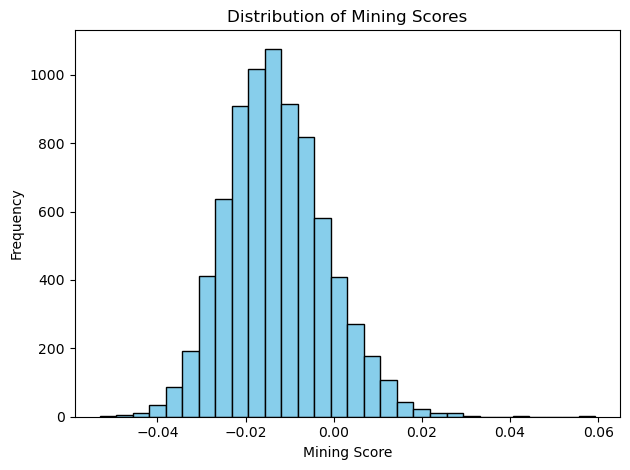

PRECISION,RECALL,F1
0.1271186440677966,0.12048192771084337,0.12371134020618557
Training dataset threshold for similarity score is 0.009344602672421518
2025-07-12 16:39:02,413 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.sinhala.furina-indic.source.vec
2025-07-12 16:39:06,227 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/si-en/test.sinhala.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-12T16:39:06.227072', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-12 16:39:06,228 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.english.furina-indic.target.vec
2025-07-12 16:39:10,018 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded

100%|██████████| 23248/23248 [00:00<00:00, 51316.08it/s]

2025-07-12 16:39:19,607 | WARNING | root | Saving results...


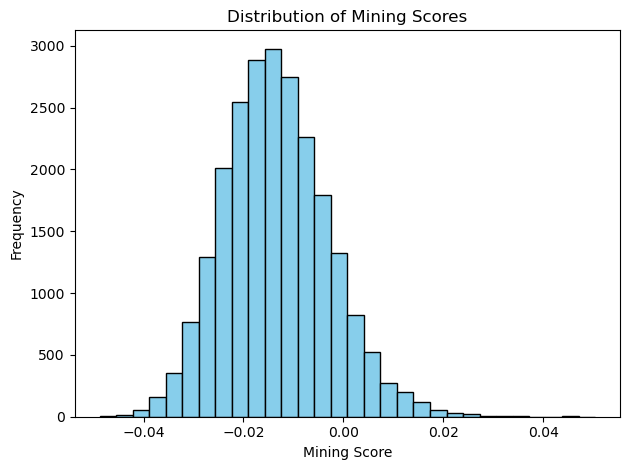

PRECISION,RECALL,F1
0.23738317757009345,0.1697860962566845,0.19797349961028843


In [10]:
run_experiment("furina-indic", 
               "data/en-si/sin_wikipedia_2021_30K-sentences.txt",
               "data/en-si/eng_news_2024_30K-sentences.txt",
               "data/en-si/sin_Sinh.dev",
               "data/en-si/eng_Latn.dev",
               ["sinhala", "english"]
               )

Batches: 100%|██████████| 243/243 [05:15<00:00,  1.30s/it]


2025-07-14 14:32:50,954 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-07-14 14:32:50,998 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-07-14 14:32:51,006 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-07-14 14:32:51,007 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/train.english.labse.source.vec
2025-07-14 14:32:52,147 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-ne/train.english.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-14T14:32:52.147475', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-14 14:32:52

100%|██████████| 7749/7749 [00:00<00:00, 46932.79it/s]

2025-07-14 14:32:54,658 | WARNING | root | Saving results...


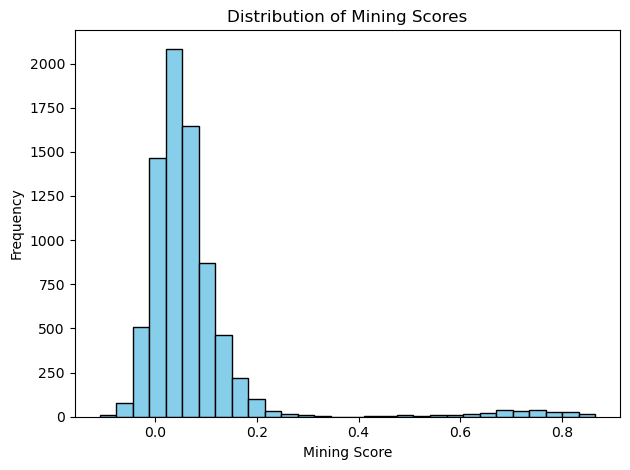

PRECISION,RECALL,F1
1.0,0.9959839357429718,0.9979879275653923
Training dataset threshold for similarity score is 0.3279829088455769


Batches: 100%|██████████| 727/727 [16:27<00:00,  1.36s/it]


2025-07-14 15:04:27,824 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/test.english.labse.source.vec
2025-07-14 15:04:31,646 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-ne/test.english.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-14T15:04:31.646232', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-14 15:04:31,647 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/test.nepali.labse.target.vec
2025-07-14 15:04:35,377 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-ne/test.nepali.labse.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-14T15:04:35.377309', 'gensim

100%|██████████| 23248/23248 [00:00<00:00, 51749.79it/s]

2025-07-14 15:04:44,486 | WARNING | root | Saving results...


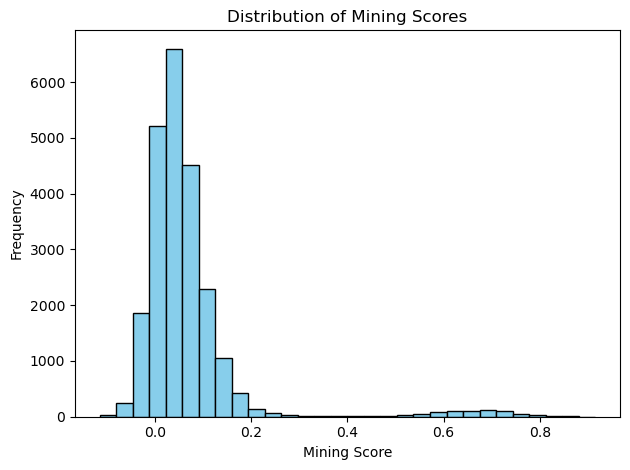

PRECISION,RECALL,F1
0.9933065595716198,0.9919786096256684,0.9926421404682274


In [7]:
run_experiment("labse", 
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_Latn.dev",
               "data/en-ne/npi_Deva.dev",
               ["english", "nepali"]
               )

/home/tanmay/miniconda3/envs/thesis_env/lib/python3.9/site-packages/fairseq/models/transformer/transformer_encoder.py:281: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  x = torch._nested_tensor_from_mask(


2025-07-07 15:32:16,639 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-07-07 15:32:16,671 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-07-07 15:32:16,678 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-07-07 15:32:16,679 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/train.english.laser.source.vec
2025-07-07 15:32:18,246 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 1024) matrix of type float32 from evaluation/en-ne/train.english.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-07T15:32:18.246575', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-07 15:32:1

100%|██████████| 7749/7749 [00:00<00:00, 50815.37it/s]

2025-07-07 15:32:21,313 | WARNING | root | Saving results...


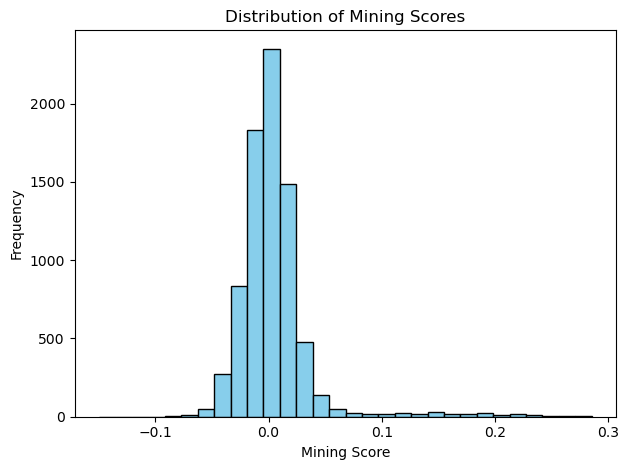

PRECISION,RECALL,F1
0.9612068965517241,0.8955823293172691,0.9272349272349272
Training dataset threshold for similarity score is 0.07282230555037555
2025-07-07 16:22:58,101 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/test.english.laser.source.vec
2025-07-07 16:23:03,264 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix of type float32 from evaluation/en-ne/test.english.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-07T16:23:03.264416', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-07 16:23:03,265 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/test.nepali.laser.target.vec
2025-07-07 16:23:08,427 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix of

100%|██████████| 23248/23248 [00:00<00:00, 49675.78it/s]

2025-07-07 16:23:24,598 | WARNING | root | Saving results...


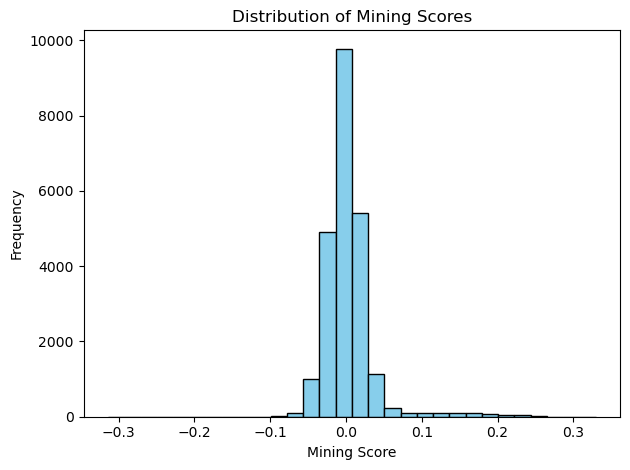

PRECISION,RECALL,F1
0.9189985272459499,0.8342245989304813,0.8745620182200419


In [7]:
run_experiment("laser", 
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_Latn.dev",
               "data/en-ne/npi_Deva.dev",
               ["english", "nepali"]
               )

2025-07-07 16:38:38,985 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/train.english.furina.source.vec
2025-07-07 16:38:40,238 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-ne/train.english.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-07T16:38:40.238201', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-07 16:38:40,238 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/train.nepali.furina.target.vec
2025-07-07 16:38:41,552 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-ne/train.nepali.furina.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-07T16:38:41.552767', '

100%|██████████| 7749/7749 [00:00<00:00, 51371.65it/s]

2025-07-07 16:38:42,756 | WARNING | root | Saving results...


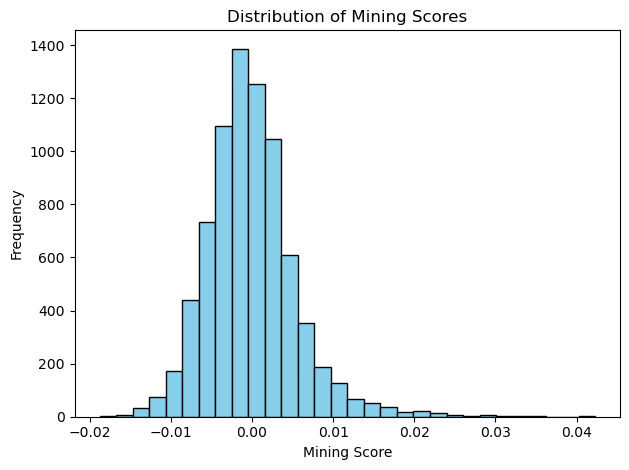

PRECISION,RECALL,F1
0.5128205128205128,0.5622489959839357,0.5363984674329502
Training dataset threshold for similarity score is 0.010907113542871842
2025-07-07 17:25:36,959 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/test.english.furina.source.vec
2025-07-07 17:25:41,220 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-ne/test.english.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-07T17:25:41.220301', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-07 17:25:41,221 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/test.nepali.furina.target.vec
2025-07-07 17:25:45,422 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix 

100%|██████████| 23248/23248 [00:00<00:00, 46404.02it/s]

2025-07-07 17:25:58,751 | WARNING | root | Saving results...


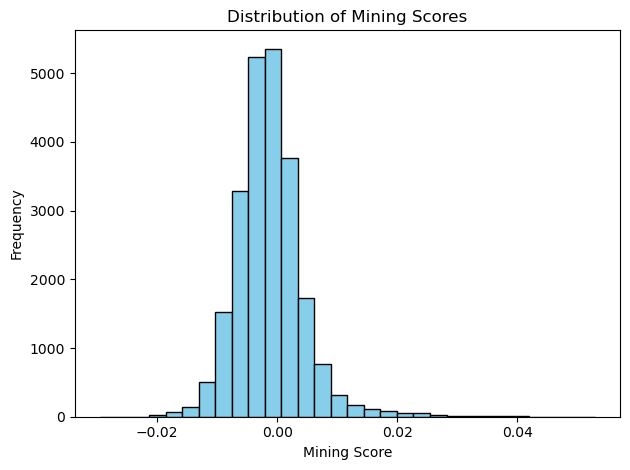

PRECISION,RECALL,F1
0.7022653721682848,0.5802139037433155,0.6354319180087847


In [8]:
run_experiment("furina", 
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_Latn.dev",
               "data/en-ne/npi_Deva.dev",
               ["english", "nepali"]
               )

2025-07-09 16:24:49,261 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-07-09 16:24:49,728 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-07-09 16:24:49,753 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-07-09 16:24:49,756 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/train.english.furina-indic.source.vec
2025-07-09 16:24:51,174 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-ne/train.english.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-09T16:24:51.173543', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-

100%|██████████| 7749/7749 [00:00<00:00, 32748.32it/s]

2025-07-09 16:24:56,248 | WARNING | root | Saving results...


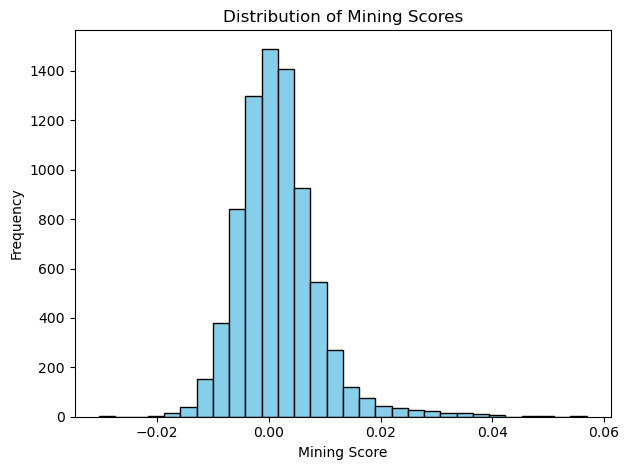

PRECISION,RECALL,F1
0.6553030303030303,0.6947791164658634,0.6744639376218323
Training dataset threshold for similarity score is 0.015839568825619876
2025-07-09 17:14:27,735 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/test.english.furina-indic.source.vec
2025-07-09 17:14:34,339 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-ne/test.english.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-09T17:14:34.339758', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-09 17:14:34,340 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/test.nepali.furina-indic.target.vec
2025-07-09 17:14:39,183 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (2

100%|██████████| 23248/23248 [00:00<00:00, 41215.77it/s]

2025-07-09 17:14:51,788 | WARNING | root | Saving results...


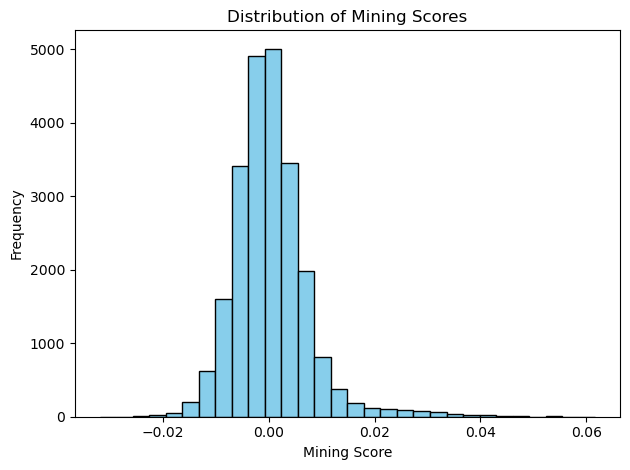

PRECISION,RECALL,F1
0.7959479015918958,0.7352941176470589,0.7644197359277276


In [7]:
run_experiment("furina-indic", 
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_Latn.dev",
               "data/en-ne/npi_Deva.dev",
               ["english", "nepali"]
               )

Skipped corpora mining as results already exist!


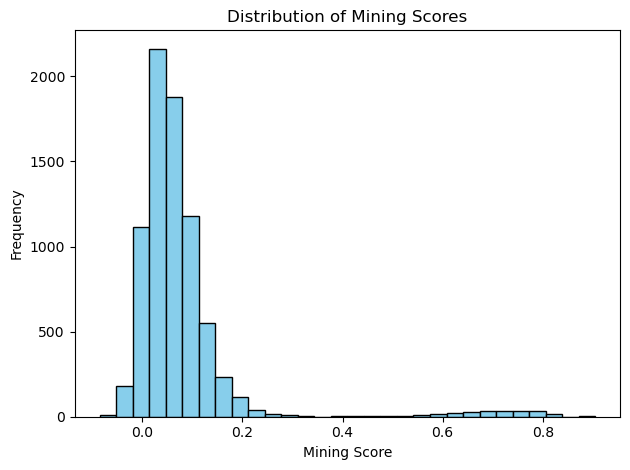

PRECISION,RECALL,F1
0.9959677419354839,0.9919678714859438,0.993963782696177
Training dataset threshold for similarity score is 0.32499460229761634


Batches: 100%|██████████| 727/727 [15:03<00:00,  1.24s/it]


2025-07-10 14:01:58,102 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/test.nepali.labse.source.vec
2025-07-10 14:02:02,023 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/ne-en/test.nepali.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T14:02:02.017310', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-10 14:02:02,023 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/test.english.labse.target.vec
2025-07-10 14:02:05,991 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/ne-en/test.english.labse.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T14:02:05.991260', 'gensim

100%|██████████| 23248/23248 [00:00<00:00, 50553.83it/s]

2025-07-10 14:02:15,082 | WARNING | root | Saving results...


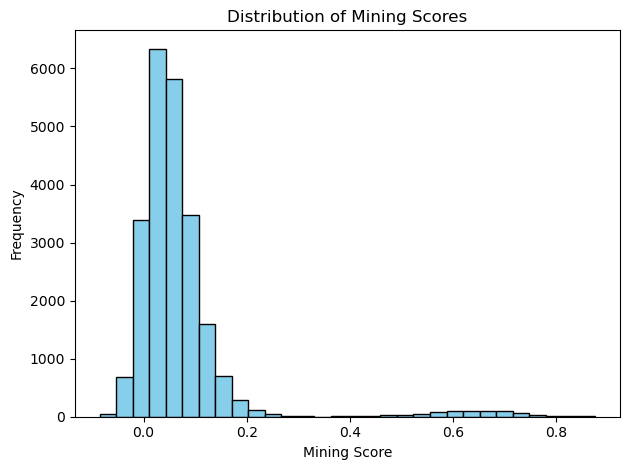

PRECISION,RECALL,F1
0.9959677419354839,0.9906417112299465,0.9932975871313673


In [26]:
run_experiment("labse", 
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/npi_Deva.dev",
               "data/en-ne/eng_Latn.dev",
               ["nepali", "english"]
               )

/home/tanmay/miniconda3/envs/thesis_env/lib/python3.9/site-packages/fairseq/models/transformer/transformer_encoder.py:281: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  x = torch._nested_tensor_from_mask(


2025-07-10 14:18:55,403 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/train.nepali.laser.source.vec
2025-07-10 14:18:56,956 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 1024) matrix of type float32 from evaluation/ne-en/train.nepali.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T14:18:56.956205', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-10 14:18:56,956 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/train.english.laser.target.vec
2025-07-10 14:18:58,497 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 1024) matrix of type float32 from evaluation/ne-en/train.english.laser.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T14:18:58.497750', 'ge

100%|██████████| 7749/7749 [00:00<00:00, 59115.43it/s]

2025-07-10 14:18:59,759 | WARNING | root | Saving results...


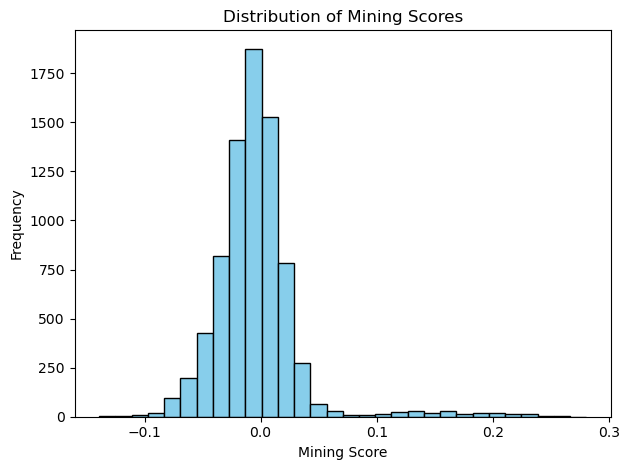

PRECISION,RECALL,F1
0.9953703703703703,0.8634538152610441,0.9247311827956989
Training dataset threshold for similarity score is 0.07099460057625641
2025-07-10 15:10:39,438 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/test.nepali.laser.source.vec
2025-07-10 15:10:45,721 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix of type float32 from evaluation/ne-en/test.nepali.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T15:10:45.721596', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-10 15:10:45,723 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/test.english.laser.target.vec
2025-07-10 15:10:51,413 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix of 

100%|██████████| 23248/23248 [00:00<00:00, 49744.07it/s]

2025-07-10 15:11:03,448 | WARNING | root | Saving results...


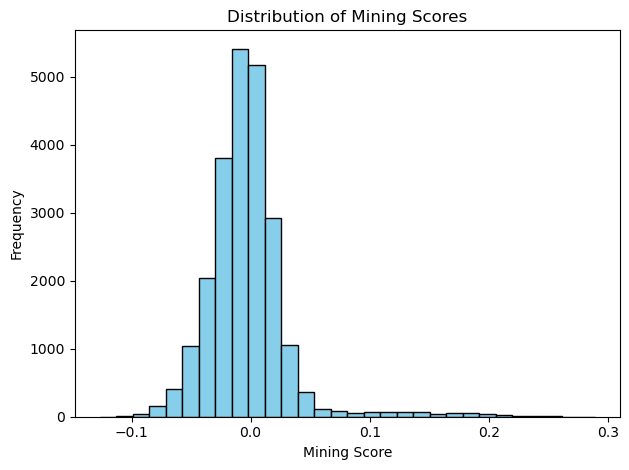

PRECISION,RECALL,F1
0.929745889387145,0.8315508021390374,0.8779110797459422


In [27]:
run_experiment("laser", 
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/npi_Deva.dev",
               "data/en-ne/eng_Latn.dev",
               ["nepali", "english"]
               )

2025-07-10 15:27:45,642 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/train.nepali.furina.source.vec
2025-07-10 15:27:47,277 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/ne-en/train.nepali.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T15:27:47.277299', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-10 15:27:47,278 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/train.english.furina.target.vec
2025-07-10 15:27:48,893 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/ne-en/train.english.furina.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T15:27:48.893902', '

100%|██████████| 7749/7749 [00:00<00:00, 39729.10it/s]

2025-07-10 15:27:50,421 | WARNING | root | Saving results...


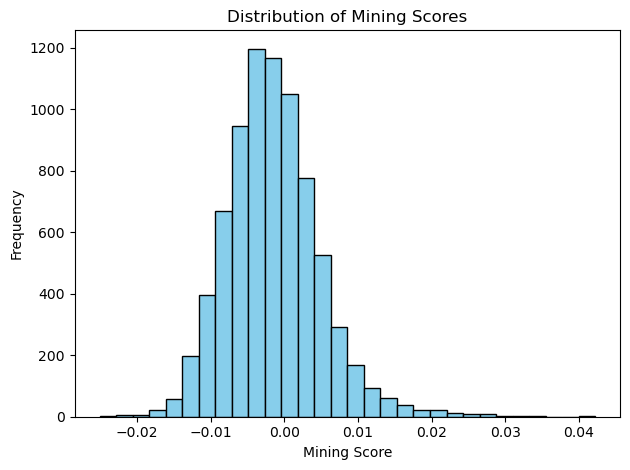

PRECISION,RECALL,F1
0.5265306122448979,0.5180722891566265,0.5222672064777328
Training dataset threshold for similarity score is 0.011136143747665373
2025-07-10 16:12:48,894 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/test.nepali.furina.source.vec
2025-07-10 16:12:52,624 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/ne-en/test.nepali.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T16:12:52.624620', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-10 16:12:52,625 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/test.english.furina.target.vec
2025-07-10 16:12:56,495 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix o

100%|██████████| 23248/23248 [00:00<00:00, 51920.58it/s]

2025-07-10 16:13:05,461 | WARNING | root | Saving results...


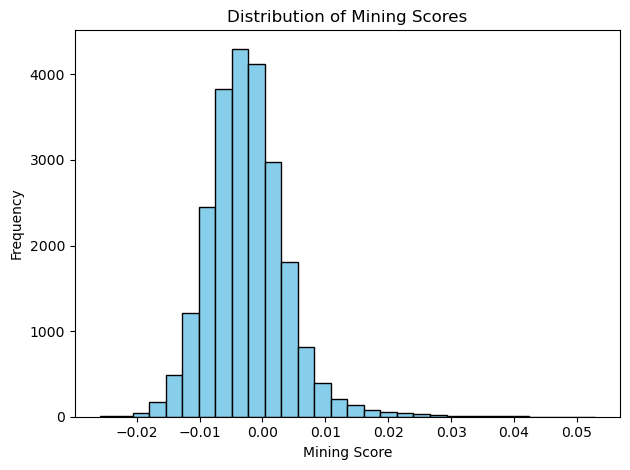

PRECISION,RECALL,F1
0.6672268907563025,0.5307486631016043,0.5912137006701416


In [28]:
run_experiment("furina", 
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/npi_Deva.dev",
               "data/en-ne/eng_Latn.dev",
               ["nepali", "english"]
               )

2025-07-10 16:28:01,907 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/train.nepali.furina-indic.source.vec
2025-07-10 16:28:03,246 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/ne-en/train.nepali.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T16:28:03.246112', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-10 16:28:03,246 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/train.english.furina-indic.target.vec
2025-07-10 16:28:04,572 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/ne-en/train.english.furina-indic.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-0

100%|██████████| 7749/7749 [00:00<00:00, 46802.09it/s]

2025-07-10 16:28:05,795 | WARNING | root | Saving results...


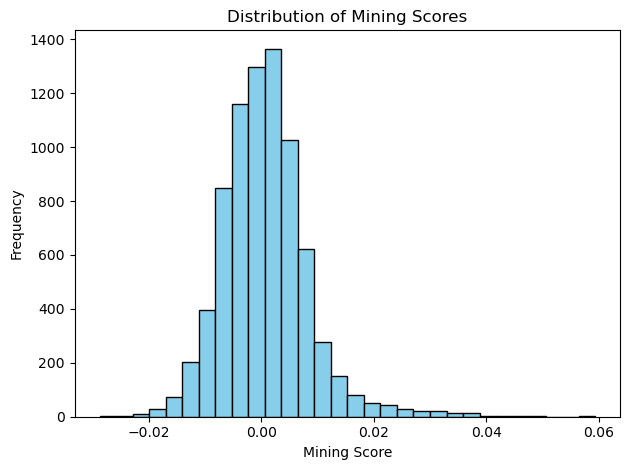

PRECISION,RECALL,F1
0.6417322834645669,0.6546184738955824,0.6481113320079523
Training dataset threshold for similarity score is 0.016037900850916918
2025-07-10 17:12:27,173 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/test.nepali.furina-indic.source.vec
2025-07-10 17:12:31,430 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/ne-en/test.nepali.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-10T17:12:31.430503', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-10 17:12:31,431 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/ne-en/test.english.furina-indic.target.vec
2025-07-10 17:12:36,882 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23

100%|██████████| 23248/23248 [00:00<00:00, 49372.69it/s]

2025-07-10 17:12:46,993 | WARNING | root | Saving results...


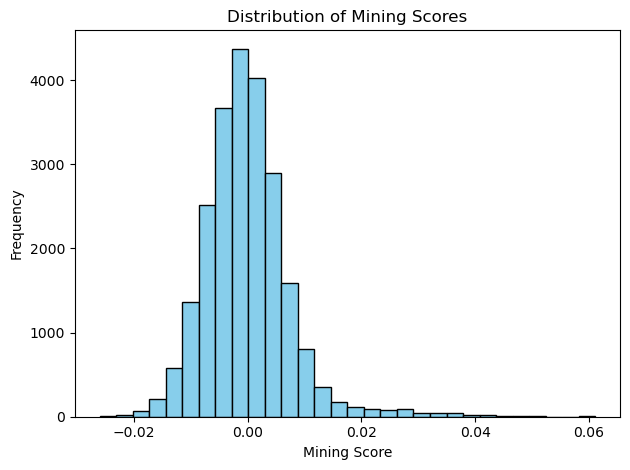

PRECISION,RECALL,F1
0.8012048192771084,0.7112299465240641,0.7535410764872521


In [ ]:
run_experiment("furina-indic", 
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/npi_Deva.dev",
               "data/en-ne/eng_Latn.dev",
               ["nepali", "english"]
               )